## Examples using KNearestNeighborsClassifier

### Import Libraries

In [1]:
import numpy as np
import torch

from sklearn.datasets import make_classification, make_blobs

from KNearestNeighborsClassifier import KNearestNeighborsClassifier

from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 
import fastkde
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt

In [2]:
seed = int('dada441', 16)

### Application on Randomly Generated Dataset

In [37]:
# Simulate data
centers = [(-1, -1), (1, 1)]
cluster_std = [0.7, 1]

X, y = make_blobs(n_samples=200, random_state=seed)
(X.shape, y.shape)

((200, 2), (200,))

In [45]:
split = 160
Xtrain = torch.tensor(X[:split])
Xtest = torch.tensor(X[split:])
ytrain = torch.tensor(y[:split])
ytest = torch.tensor(y[split:])

knnc = KNearestNeighborsClassifier()
knnc.fit(Xtrain, ytrain)
y_preds = knnc.predict(Xtest)

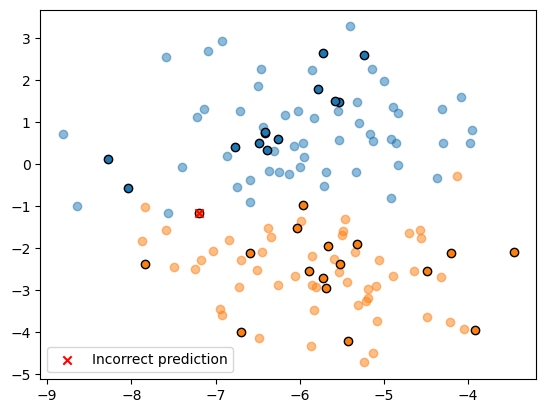

In [70]:
colors = ['tab:blue', 'tab:orange']

for label in (0,1):
    plt.scatter(Xtrain[:,0][ytrain == label], Xtrain[:,1][ytrain == label], color=colors[label], alpha=0.5) # Training data (alpha=0.5)
    plt.scatter(Xtest[:,0][y_preds == label], Xtest[:,1][y_preds == label], color=colors[label], ec='black') # Testing data and prediction (alpha=1)
plt.scatter(Xtest[:,0][ytest != y_preds], Xtest[:,1][ytest != y_preds], marker='x', color='red', label='Incorrect prediction') # marker='x'
plt.legend()
plt.show()

### Hyperparameter Tuning on Randomly Generated Dataset with Class Imbalance

In [4]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=seed)

print(X.shape, y.shape)

(10000, 2) (10000,)


In [72]:
print("Number of 0's:", len(y[y == 0]))
print("Number of 1's:", len(y[y == 1]))

Number of 0's: 9900
Number of 1's: 100


In [14]:
def plot_data(X, y, labels = [0,1], alpha = 0.5):
    for y_val in labels:
        plt.scatter(X[:,0][y == y_val], X[:,1][y == y_val], alpha = alpha, label = y_val)
    plt.legend()
    plt.show()

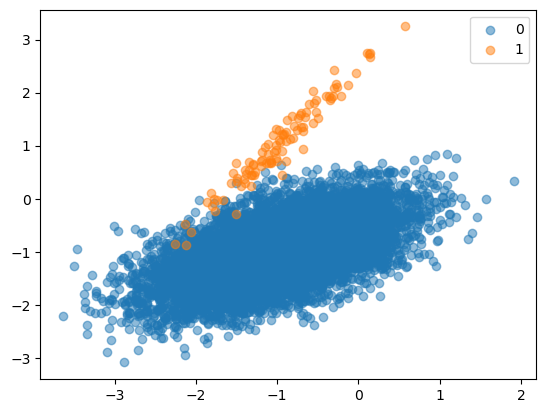

In [74]:
plot_data(X, y)

In [32]:
def DoKFold(X:np.array, y:np.array, model, labels = [0,1], n_splits = 5):
    '''
    Perform stratified k-fold validation.

    Args:
        X: Sample data
        y: Target values/labels
        model: Model to fit and predict with
        labels: Unique labels
        n_splits: Number of splits for the stratified k-fold validation

    Returns:
        The average accuracy, as well as the average precision and recall scores for each target value in the order given by labels.
        For example: accuracy, [precision for y=0, precision for y=1], [recall for y=0, precision for y=1]
    '''
    accuracy = []
    precision = []
    recall = []

    skf = StratifiedKFold(n_splits=n_splits)
    for idx_train, idx_test in skf.split(X, y):
        Xtrain = X[idx_train]
        Xtest = X[idx_test]
        ytrain = y[idx_train]
        ytest = y[idx_test]

        model.fit(Xtrain, ytrain)
        y_pred = model.predict(Xtest)

        accuracy.append(sum(ytest == y_pred) / len(ytest))
        results = precision_recall_fscore_support(ytest, y_pred, labels = labels)
        precision.append(results[0])
        recall.append(results[1])
    
    # Return average precision and recall scores for each target value
    return np.mean(accuracy), np.mean(precision, axis=0), np.mean(recall, axis=0)

In [33]:
# accuracy, [precision for y=0, precision for y=1], [recall for y=0, precision for y=1]
DoKFold(X, y, KNearestNeighborsClassifier()) 

(0.9983000000000001,
 array([0.99879042, 0.94502924]),
 array([0.99949495, 0.88      ]))

In [10]:
# ([precision for y=0, precision for y=1], [recall for y=0, precision for y=1])
DoKFold(X, y, KNearestNeighborsClassifier()) 

(array([0.99879042, 0.94502924]), array([0.99949495, 0.88      ]))

In [36]:
def try_n_neighbors(n_neighbors_list:list, X:torch.Tensor, y:torch.Tensor, labels = [0,1], n_splits = 5):
    '''
    Perform stratified k-fold validation for each n_neighbors hyperparameter value in n_neighbors list.

    Args:
        n_neighbors_list: List of n_neighbors to try
        X: Sample data
        y: Target values/labels
        labels: Unique labels
        n_splits: Number of splits for the stratified k-fold validation 
    '''
    precision_scores = []
    recall_scores = []
    for n in n_neighbors_list:
        print("Performing stratified k-fold validation with n_neighbors =", n)
        accuracy, precision, recall = DoKFold(X, y, KNearestNeighborsClassifier(n_neighbors=n), labels=labels, n_splits=n_splits) 
                
        # Print results
        print("\t", end = "")
        for label in [0,1]:
            print(f"\t{label}", end = "")
        print("\nPrecision\t", end = "")
        for p in precision:
            print(f"{round(p, 5)}\t", end = "")
        print("\nRecall\t\t", end = "")
        for r in recall:
            print(f"{round(r, 5)}\t", end = "")
        print("\nOverall accuracy:", accuracy)

In [37]:
n_neighbors_list = np.arange(3, 22, 2)
try_n_neighbors(n_neighbors_list, X, y, n_splits=10)

Performing stratified k-fold validation with n_neighbors = 3
		0	1
Precision	0.99889	0.94265	
Recall		0.99939	0.89	
Overall accuracy: 0.9982999999999999
Performing stratified k-fold validation with n_neighbors = 5
		0	1
Precision	0.99889	0.95023	
Recall		0.99949	0.89	
Overall accuracy: 0.9984
Performing stratified k-fold validation with n_neighbors = 7
		0	1
Precision	0.99899	0.95023	
Recall		0.99949	0.9	
Overall accuracy: 0.9984999999999999
Performing stratified k-fold validation with n_neighbors = 9
		0	1
Precision	0.99879	0.94844	
Recall		0.99949	0.88	
Overall accuracy: 0.9982999999999999
Performing stratified k-fold validation with n_neighbors = 11
		0	1
Precision	0.99869	0.96273	
Recall		0.9996	0.87	
Overall accuracy: 0.9983000000000001
Performing stratified k-fold validation with n_neighbors = 13
		0	1
Precision	0.99859	0.95273	
Recall		0.99949	0.86	
Overall accuracy: 0.9981
Performing stratified k-fold validation with n_neighbors = 15
		0	1
Precision	0.99849	0.97182	
Recall		0.9

Number of samples: 19800
Number of 0's: 9900
Number of 1's: 9900


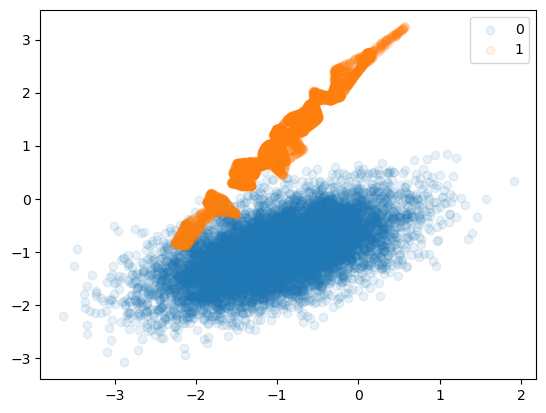

In [38]:
# Synthetic minority oversampling (SMOTE)
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

print("Number of samples:", len(y_smote))
print("Number of 0's:", len(y_smote[y_smote == 0]))
print("Number of 1's:", len(y_smote[y_smote == 1]))
plot_data(X_smote, y_smote, alpha=0.1)

In [39]:
try_n_neighbors(n_neighbors_list, X_smote, y_smote, n_splits=10)

Performing stratified k-fold validation with n_neighbors = 3
		0	1
Precision	0.99909	0.99388	
Recall		0.99384	0.99909	
Overall accuracy: 0.9964646464646464
Performing stratified k-fold validation with n_neighbors = 5
		0	1
Precision	1.0	0.99348	
Recall		0.99343	1.0	
Overall accuracy: 0.9967171717171718
Performing stratified k-fold validation with n_neighbors = 7
		0	1
Precision	1.0	0.99268	
Recall		0.99263	1.0	
Overall accuracy: 0.9963131313131314
Performing stratified k-fold validation with n_neighbors = 9
		0	1
Precision	1.0	0.99219	
Recall		0.99212	1.0	
Overall accuracy: 0.9960606060606061
Performing stratified k-fold validation with n_neighbors = 11
		0	1
Precision	1.0	0.99199	
Recall		0.99192	1.0	
Overall accuracy: 0.995959595959596
Performing stratified k-fold validation with n_neighbors = 13
		0	1
Precision	1.0	0.99169	
Recall		0.99162	1.0	
Overall accuracy: 0.9958080808080807
Performing stratified k-fold validation with n_neighbors = 15
		0	1
Precision	1.0	0.99149	
Recall		0.99

Number of samples: 19804
Number of 0's: 9900
Number of 1's: 9904


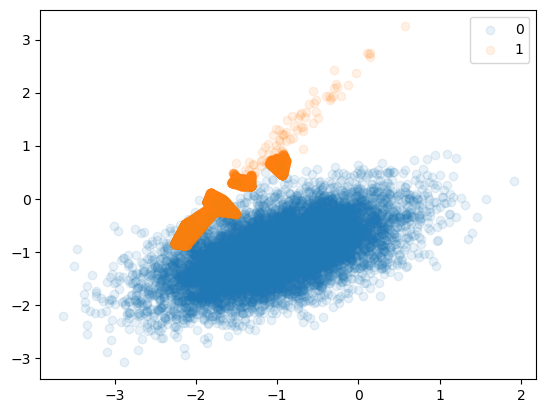

In [40]:
# Adaptive synthetic oversampling (ADASYN)
adasyn = ADASYN(random_state = seed)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

print("Number of samples:", len(X_adasyn))
print("Number of 0's:", len(y_adasyn[y_adasyn == 0]))
print("Number of 1's:", len(y_adasyn[y_adasyn == 1]))
plot_data(X_adasyn, y_adasyn, alpha=0.1)

In [41]:
try_n_neighbors(n_neighbors_list, X_adasyn, y_adasyn, n_splits=10)

Performing stratified k-fold validation with n_neighbors = 3
		0	1
Precision	0.96063	0.99329	
Recall		0.99384	0.93859	
Overall accuracy: 0.9662129880327761
Performing stratified k-fold validation with n_neighbors = 5
		0	1
Precision	0.964	0.99288	
Recall		0.99343	0.94475	
Overall accuracy: 0.9690918014062889
Performing stratified k-fold validation with n_neighbors = 7
		0	1
Precision	0.9656	0.99207	
Recall		0.99253	0.94849	
Overall accuracy: 0.970506044799331
Performing stratified k-fold validation with n_neighbors = 9
		0	1
Precision	0.96691	0.99123	
Recall		0.99162	0.95141	
Overall accuracy: 0.9715161967988823
Performing stratified k-fold validation with n_neighbors = 11
		0	1
Precision	0.96752	0.99066	
Recall		0.99101	0.95273	
Overall accuracy: 0.9718698341313182
Performing stratified k-fold validation with n_neighbors = 13
		0	1
Precision	0.96827	0.98995	
Recall		0.99051	0.95434	
Overall accuracy: 0.9724253641921485
Performing stratified k-fold validation with n_neighbors = 15
		0	

Number of samples: 129
Number of 0's: 65
Number of 1's: 64


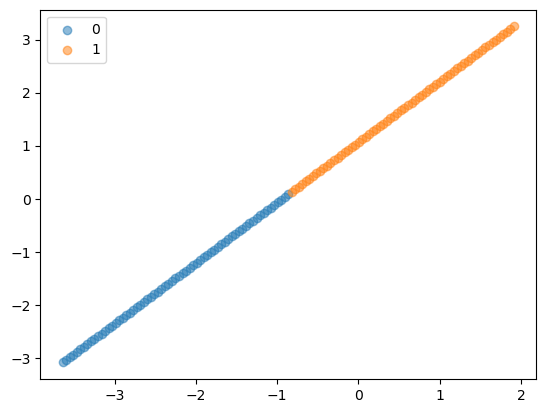

In [42]:
# FastKDE sampling
PDF = fastkde.pdf(X[:,0], X[:,1], y, var_names = ['X1', 'X2', 'y'])
x1 = np.array(PDF.X1)
x2 = np.array(PDF.X2)
X_fastkde = np.stack([x1, x2], axis=1)
y_fastkde = np.array([round(float(num)) for num in PDF.y])

print("Number of samples:", len(X_fastkde))
print("Number of 0's:", len(y_fastkde[y_fastkde == 0]))
print("Number of 1's:", len(y_fastkde[y_fastkde == 1]))
plot_data(X_fastkde, y_fastkde)

In [43]:
try_n_neighbors(n_neighbors_list, X_fastkde, y_fastkde, n_splits=10)

Performing stratified k-fold validation with n_neighbors = 3
		0	1
Precision	0.97	0.96667	
Recall		0.95	0.95	
Overall accuracy: 0.951923076923077
Performing stratified k-fold validation with n_neighbors = 5
		0	1
Precision	0.97	0.96667	
Recall		0.95	0.95	
Overall accuracy: 0.951923076923077
Performing stratified k-fold validation with n_neighbors = 7
		0	1
Precision	0.97	0.96667	
Recall		0.95	0.95	
Overall accuracy: 0.951923076923077
Performing stratified k-fold validation with n_neighbors = 9
		0	1
Precision	0.97	0.96667	
Recall		0.95	0.95	
Overall accuracy: 0.951923076923077
Performing stratified k-fold validation with n_neighbors = 11
		0	1
Precision	0.97	0.96667	
Recall		0.95	0.95	
Overall accuracy: 0.951923076923077
Performing stratified k-fold validation with n_neighbors = 13
		0	1
Precision	0.97	0.96667	
Recall		0.95	0.95	
Overall accuracy: 0.951923076923077
Performing stratified k-fold validation with n_neighbors = 15
		0	1
Precision	0.97	0.96667	
Recall		0.95	0.95	
Overall acc